In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
import joblib
import imblearn
from sklearn.inspection import permutation_importance

In [38]:
df = pd.read_csv("data/cleaned_data.csv")

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45487 entries, 0 to 45486
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 45487 non-null  int64  
 1   amount_tsh         45487 non-null  float64
 2   funder             45487 non-null  object 
 3   gps_height         45487 non-null  float64
 4   installer          45487 non-null  object 
 5   longitude          45487 non-null  float64
 6   latitude           45487 non-null  float64
 7   basin              45487 non-null  object 
 8   region             45487 non-null  object 
 9   region_code        45487 non-null  int64  
 10  district_code      45487 non-null  int64  
 11  population         45487 non-null  float64
 12  construction_year  45487 non-null  int64  
 13  payment_type       45487 non-null  object 
 14  quantity           45487 non-null  object 
 15  source             45487 non-null  object 
 16  waterpoint_type    454

We need to select the columns we want to use for the modelling part.
This selection process going to be an iterative process.


In [40]:
feat_cols = ["amount_tsh", "gps_height", "longitude", "latitude", "population", "construction_year", "payment_type", "quantity", "source", "waterpoint_type", "basin"]

df_label = df["status_group"]
df = df[feat_cols]

## Create Pipeline

In [41]:
numerical_cols = df.select_dtypes('number').columns
categorical_cols = pd.Index(np.setdiff1d(df.columns, numerical_cols))

numerical_pipe = Pipeline([
    ('scaler', StandardScaler())])

categorical_pipe = Pipeline([(
    'encoder', OneHotEncoder(handle_unknown='error'))])

preprocessors = ColumnTransformer(transformers=[
    ('num', numerical_pipe, numerical_cols),
    ('cat', categorical_pipe, categorical_cols)
    ])

pipe = Pipeline([('preprocessors', preprocessors), ('model', RandomForestClassifier())])

### Divide into Train and test data
* Use Smote Technique for oversampling
* Train/Test split: 0.8,0.2

In [42]:
X_train, X_test, y_train, y_test = train_test_split(df, df_label, test_size=0.2, random_state=42)

smote_nc = imblearn.over_sampling.SMOTENC(categorical_features=[df.columns.get_loc(col) for col in categorical_cols], random_state=42)
X_train, y_train = smote_nc.fit_resample(X_train, y_train)

## Gridsearch with 4-fold cross validation

In [43]:
parameters = {'model__n_estimators': (300, 400),'model__max_depth': (10, 15)}
model = GridSearchCV(pipe, parameters, cv=2, n_jobs=-1)
model.fit(X_train,y_train)

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('preprocessors',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['amount_tsh', 'gps_height', 'longitude', 'latitude', 'population',
       'construction_year'],
      dtype='object')),
                                                                        ('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder())]),
                                                                         Index(['basin', 'payment_type', 'quantity', 'source', 'waterpoint_type'], dtype='object'))])),
                                       ('model', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'model__max_depth': (5, 10),
                         'model__n_estimators': (300, 400)})

## Plot gridsearch results and test result of tuned model(accuracy and confusion matrix)

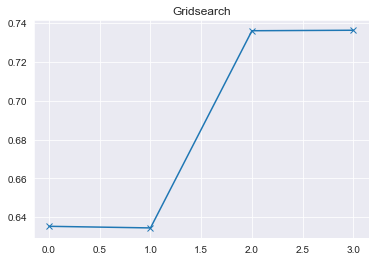

Best hyperparameter settings: {'model__max_depth': 10, 'model__n_estimators': 400}


In [44]:
plt.plot(np.arange(model.cv_results_.get('mean_test_score').size), model.cv_results_.get('mean_test_score'), marker="x")
plt.title("Gridsearch")
plt.show()
print('Best hyperparameter settings: {}'.format(model.best_params_))

Training Accuracy: 0.7521626844377021
Test Accuracy: 0.6766322268630468


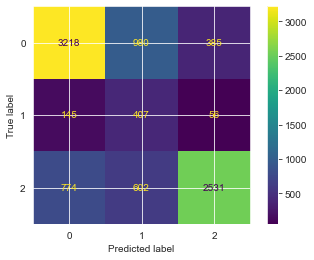

In [45]:
print(f"Training Accuracy: {accuracy_score(y_train, model.predict(X_train))}")

preds = model.predict(X_test)
print(f"Test Accuracy: {accuracy_score(y_test, preds)}")

cm = confusion_matrix(y_test, preds)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm)
cmd.plot()
plt.show()

### Plot feature importances

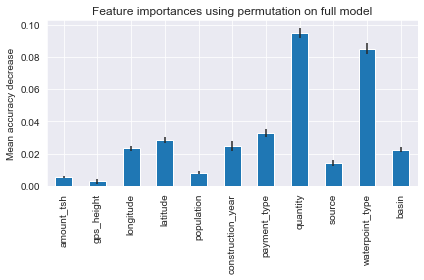

In [50]:
result = permutation_importance(
    model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
)

forest_importances = pd.Series(result.importances_mean, index=feat_cols)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
fig.savefig("data/feature_importances.png")
plt.show()

Save model

In [46]:
joblib.dump(model, "./model_pipe.joblib")

['./model_pipe.joblib']